<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

In [1]:
%cd ../..
%load_ext autoreload
%autoreload 2

C:\Users\julia\Documents\Imperial\DA_project


In [27]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import pipeline
import seaborn as sns
sns.set()
from matplotlib.ticker import ScalarFormatter

#sns.set_palette("Dark2")


Use a range of AEs, and a range of TSVD Tau and M 
AND non-preconditioned VarDA. Repeat this in the introduction.

In [28]:
out_fp = "report/figures/time_perf.png"
in_csv = "report/data/DA_tables - final.csv"

df = pd.read_csv(in_csv)
df

,Model,da_mse,time,Formulation
0,"$\tau = 32, M=n, \sigma_{\tau} = \sqrt{\sigma_0}$",0.200,1.50,TSVD
1,"$\tau = 32, M = 1400, \sigma_{\tau} = \sqrt{\...",0.150,0.60,TSVD
2,"$\tau = 791, M = n$",0.090,2.50,3D-VarDA
3,"$\tau = 791, M = 1400$",0.120,1.60,3D-VarDA
4,Tucodec-vanilla,0.075,0.49,CAE
5,Tucodec-vanilla-GPU,0.075,0.20,CAE
6,Tucodec-vanilla-GDN,0.200,0.53,CAE
7,GRDN-NeXt,0.230,1.40,CAE
8,ResNeXt3-27-4,0.190,0.60,CAE
9,RDB3-27-1-CBAM+vanilla,0.230,0.50,CAE


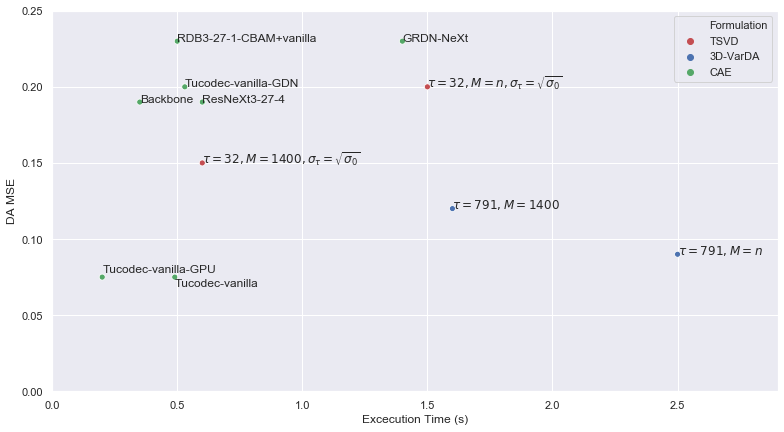

In [56]:
ax = sns.scatterplot(x="time", y="da_mse",
             hue="Formulation", #style="Subset", 
             data=df, palette=["r", "b", 'g',], marker="o")

x = df["time"].copy()
y = df["da_mse"].copy()
text = df["Model"]
ax.set_xlabel("Excecution Time (s)")
ax.set_ylabel("DA MSE")
ax.set_xlim(0, 2.9)
ax.set_ylim(0, 0.25)
for i in range(len(df)):
    texi = text[i]
    tex = r"{}".format(texi) #TODO - remove $ w new data
    if "GPU" in tex:
        y[i] += 0.003
    if tex == "Tucodec-vanilla":
        y[i] -= 0.006
    ax.annotate(tex, (x[i], y[i]), fontsize=12)
fig = ax.get_figure()
fig.set_size_inches(13, 7)
fig.savefig(out_fp)